# Perturbing initial conditions in the basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

In [6]:
def imshow3(etahuhv, negative_vlim=True,  eta_vlim=0.05, huv_vlim=2, cmap="coolwarm"):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-negative_vlim*eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [7]:
def imshow3var(est_var, eta_vlim=0.00025, huv_lim=1.0):
    return imshow3(est_var, negative_vlim=False, eta_vlim=eta_vlim, huv_vlim=huv_lim, cmap="Reds")

In [8]:
def imshowSim(sim, eta_vlim=0.05, huv_lim=2.0):
    eta, hu, hv = sim.download(interior_domain_only=False)
    return imshow3(np.array([eta, hu, hv]), eta_vlim=eta_vlim, huv_vlim=huv_lim)

### Perturbing initial conditions

In [9]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [10]:
ls = [6, 7, 8, 9, 10]

In [11]:
model_error_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    model_error_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [12]:
basis_x_start = 1
basis_x_end = 6
basis_y_start = 2
basis_y_end = 7

kl_decay = 1.25
kl_scaling = 0.025

In [13]:
mekls = []
for l_idx in range(len(ls)): 
    mekls.append( ModelErrorKL.ModelErrorKL(**model_error_args_list[l_idx], include_sin=False,
                                            basis_x_start=basis_x_start, basis_x_end=basis_x_end, basis_y_start=basis_y_start, basis_y_end=basis_y_end,
                                            kl_decay=kl_decay, kl_scaling=kl_scaling) 
                )

In [14]:
def make_init_fields(args):
    dataShape = (args["ny"] + 4, args["nx"] + 4)
    dataShapeH = (args["ny"] + 5, args["nx"] + 5)

    eta = np.zeros(dataShape, dtype=np.float32)
    hu  = np.zeros(dataShape, dtype=np.float32)
    hv  = np.zeros(dataShape, dtype=np.float32)
    Hi = np.ones(dataShapeH, dtype=np.float32)*60

    return {"eta": eta, "hu": hu, "hv": hv, "Hi": Hi}

data_args = make_init_fields(model_error_args_list[-1])

In [15]:
def make_sim(me_args, init_fields = None):
    if init_fields is None:
        init_fields = make_init_fields(me_args)

    sim_args = {
        "gpu_ctx" : gpu_ctx,
        "nx" : me_args["nx"],
        "ny" : me_args["ny"],
        "dx" : me_args["dx"],
        "dy" : me_args["dy"],
        "f"  : sample_args["f"],
        "g"  : sample_args["g"],
        "r"  : 0,
        "dt" : 0,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2),
        "eta0" : init_fields["eta"],
        "hu0"  : init_fields["hu"],
        "hv0"  : init_fields["hv"],
        "H"    : init_fields["Hi"],
    }

    return CDKLM16.CDKLM16(**sim_args)

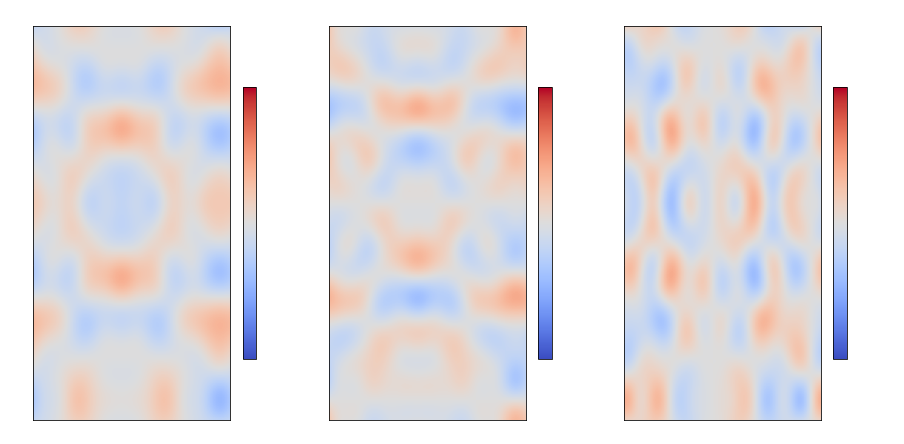

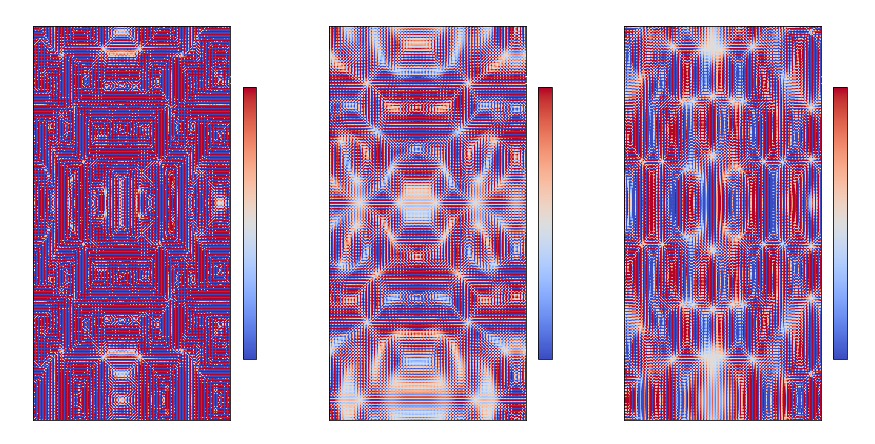

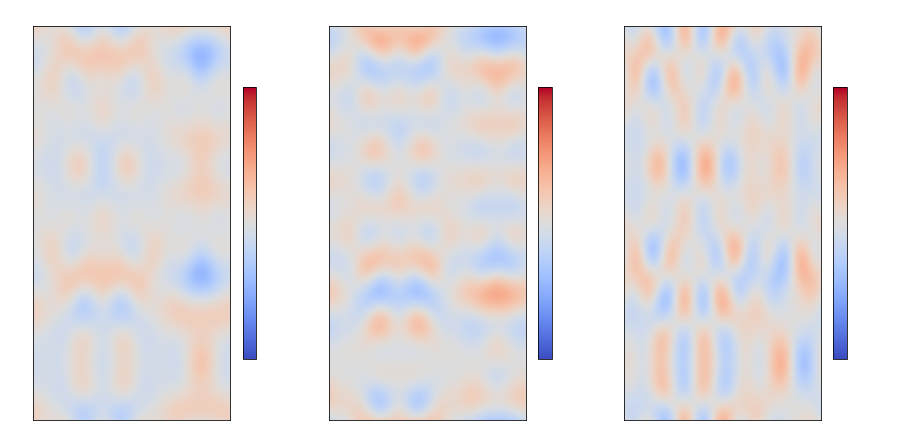

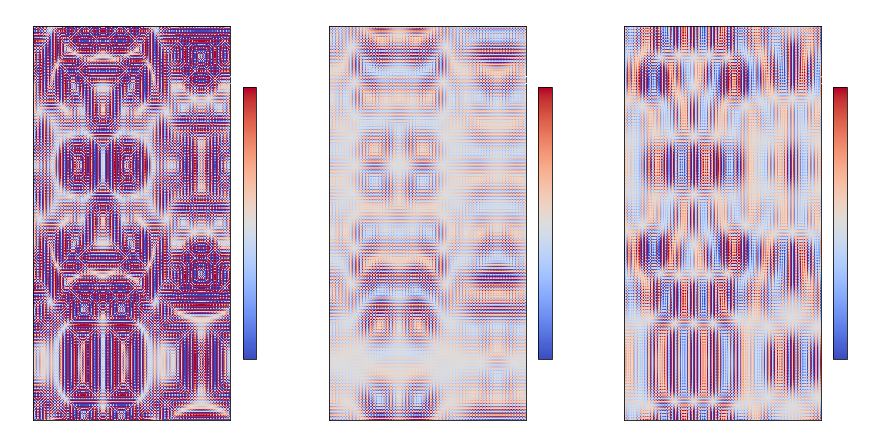

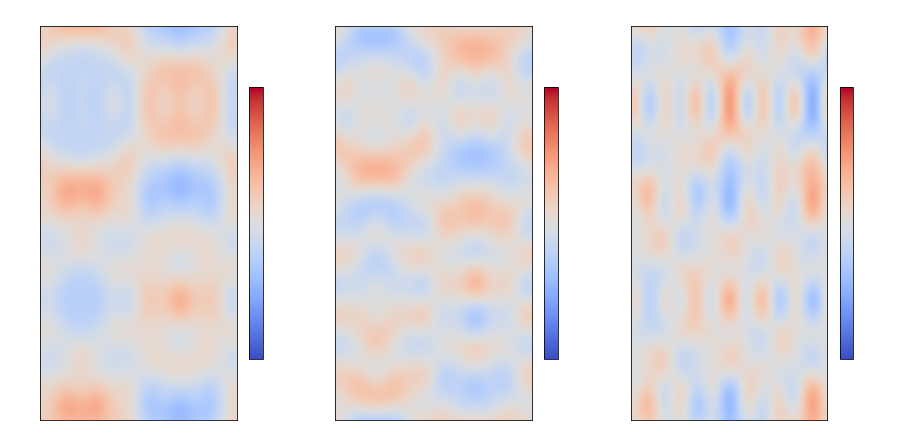

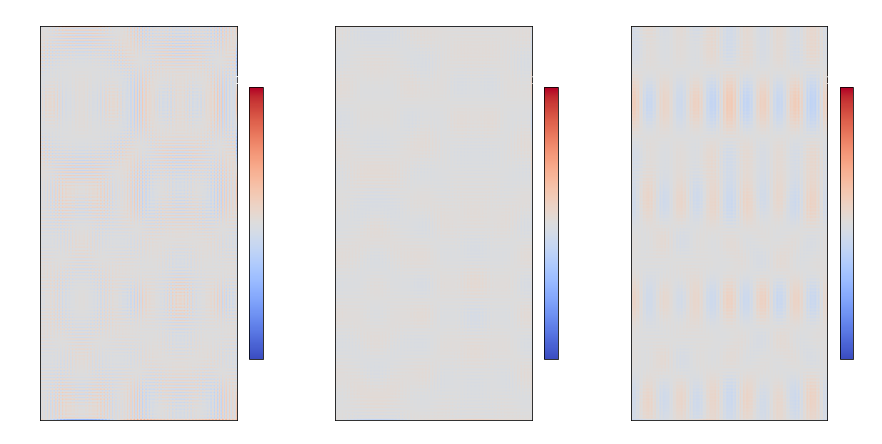

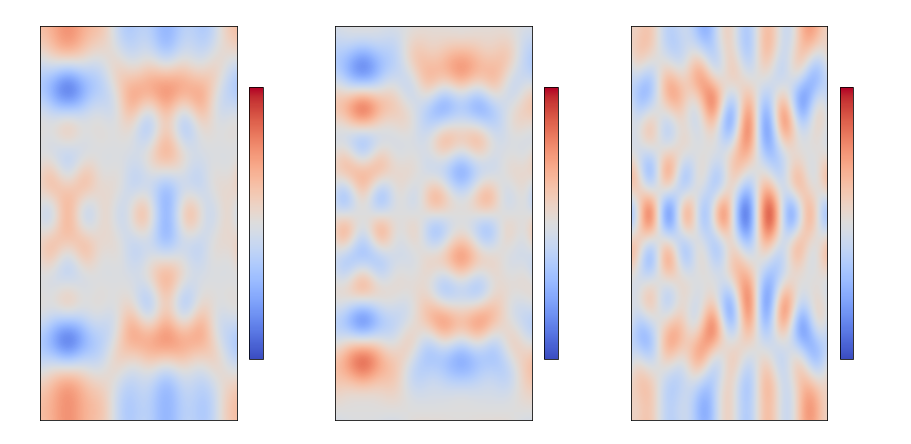

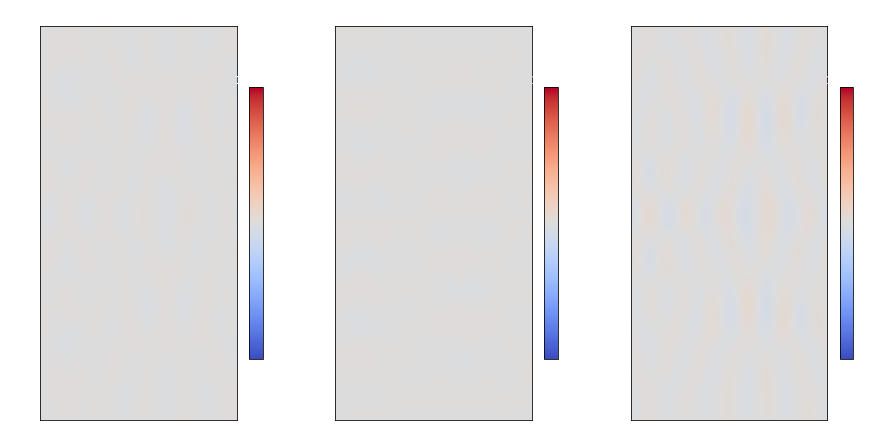

In [16]:
for l_idx in range(1,len(ls)):
    data_args = make_init_fields(model_error_args_list[l_idx])
    sim = make_sim(model_error_args_list[l_idx], data_args)
    mekls[l_idx].perturbSim(sim)

    coarse_data_args = make_init_fields(model_error_args_list[l_idx-1])
    coarse_sim = make_sim(model_error_args_list[l_idx-1], coarse_data_args)
    mekls[l_idx-1].perturbSimSimilarAs(coarse_sim, modelError=mekls[l_idx])

    etahuv = sim.download(interior_domain_only=True)
    coarse_etahuv = np.array(coarse_sim.download(interior_domain_only=True)).repeat(2,1).repeat(2,2)

    imshow3(etahuv, huv_vlim=0.01)
    imshow3(etahuv - coarse_etahuv, eta_vlim=5e-5, huv_vlim=5e-5)
    # imshow3(coarse_etahuv)


### Statistics

In [17]:
from utils.VarianceStatistics import * 

In [18]:
welford_vars = []
welford_diff_vars = []
for l_idx, l in enumerate(ls):
    welford_vars.append( WelfordsVariance3((mekls[l_idx].ny,mekls[l_idx].nx)) )
    if l_idx > 0:
        welford_diff_vars.append( WelfordsVariance3((mekls[l_idx].ny,mekls[l_idx].nx)) )

In [19]:
means = []
diff_means = []
for l_idx in range(len(ls)):
    means.append(np.zeros((3,mekls[l_idx].ny,mekls[l_idx].nx)))
    diff_means.append(np.zeros((3,mekls[l_idx].ny,mekls[l_idx].nx)))

In [20]:
for l_idx in range(len(ls)):
    N = 500
    for i in range(N):
        print(l_idx, i)
        data_args = make_init_fields(model_error_args_list[l_idx])

        sim = make_sim(model_error_args_list[l_idx], data_args)
        mekls[l_idx].perturbSim(sim)

        eta, hu, hv = sim.download(interior_domain_only=True)
        means[l_idx][0] += 1/N * eta
        means[l_idx][1] += 1/N * hu
        means[l_idx][2] += 1/N * hv
        welford_vars[l_idx].update(eta, hu, hv)

        if l_idx > 0:
            coarse_data_args = make_init_fields(model_error_args_list[l_idx-1])

            coarse_sim = make_sim(model_error_args_list[l_idx-1], coarse_data_args)
            
            mekls[l_idx-1].perturbSimSimilarAs(coarse_sim, modelError=mekls[l_idx])

            coarse_eta, coarse_hu, coarse_hv = coarse_sim.download(interior_domain_only=True)
            welford_diff_vars[l_idx-1].update(eta - coarse_eta.repeat(2,0).repeat(2,1), 
                                            hu - coarse_hu.repeat(2,0).repeat(2,1), 
                                            hv - coarse_hv.repeat(2,0).repeat(2,1))

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


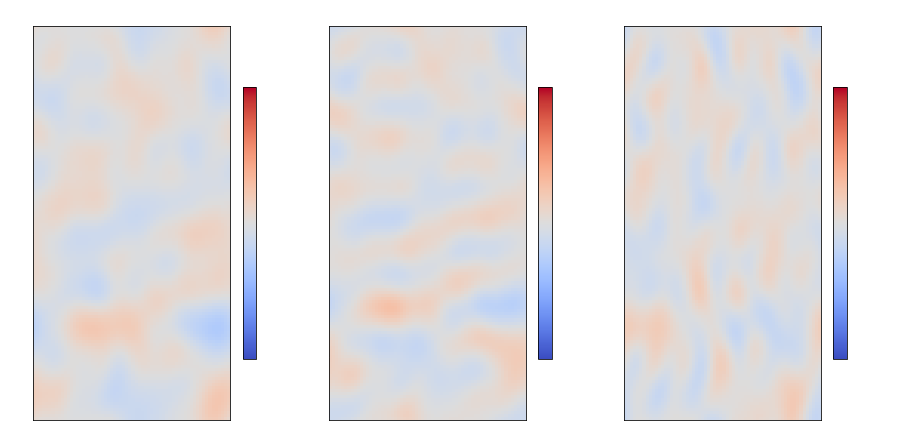

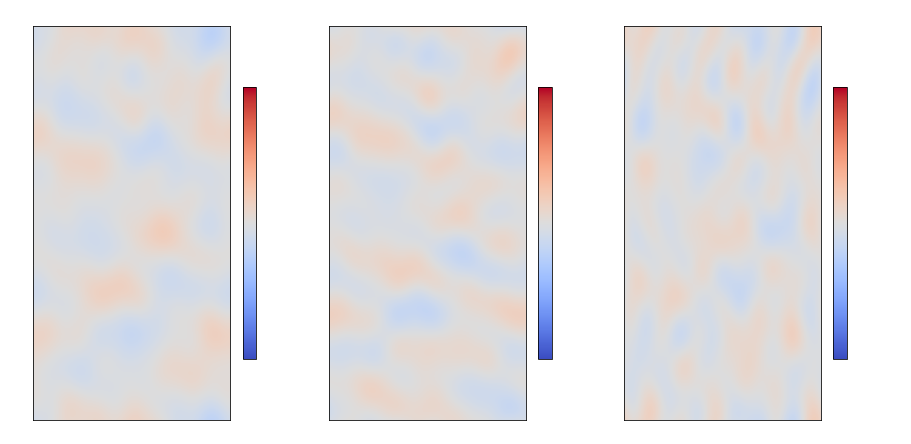

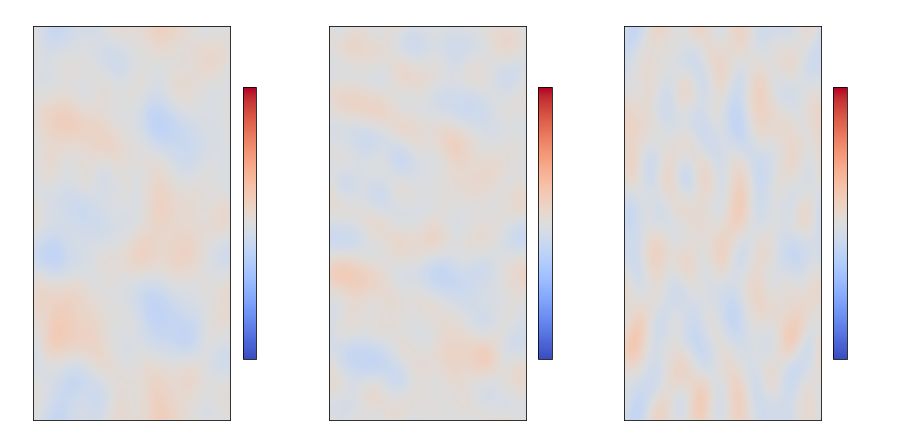

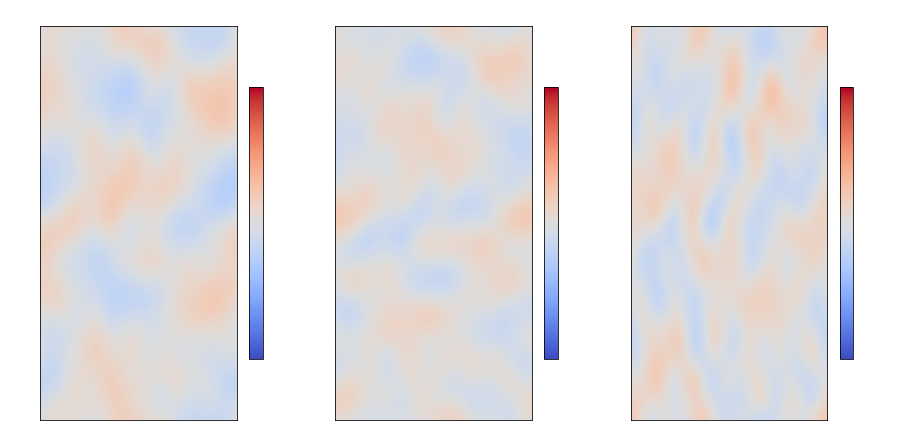

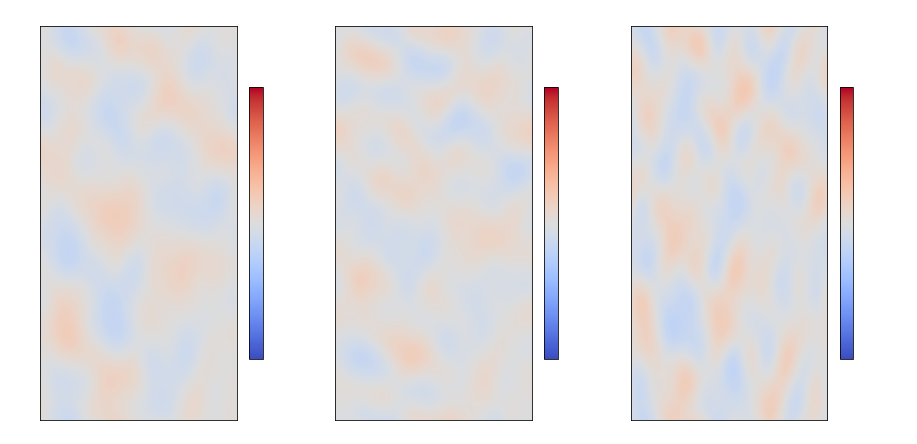

In [21]:
for l_idx in range(len(ls)):
    imshow3(means[l_idx], eta_vlim=0.005, huv_vlim=0.001)

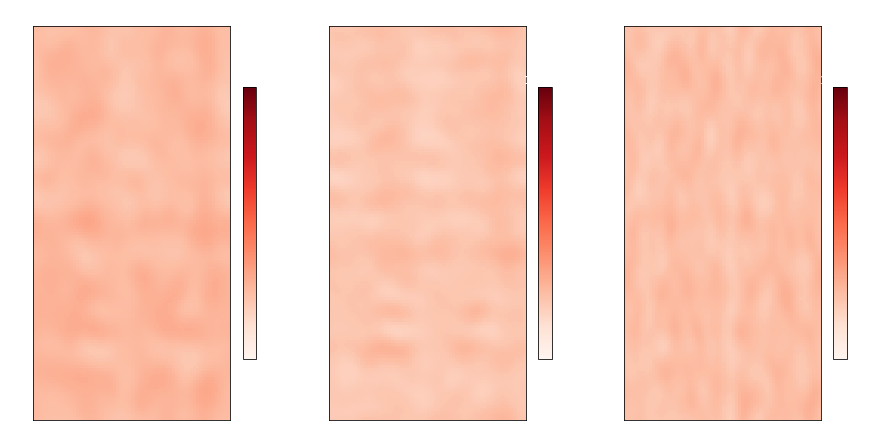

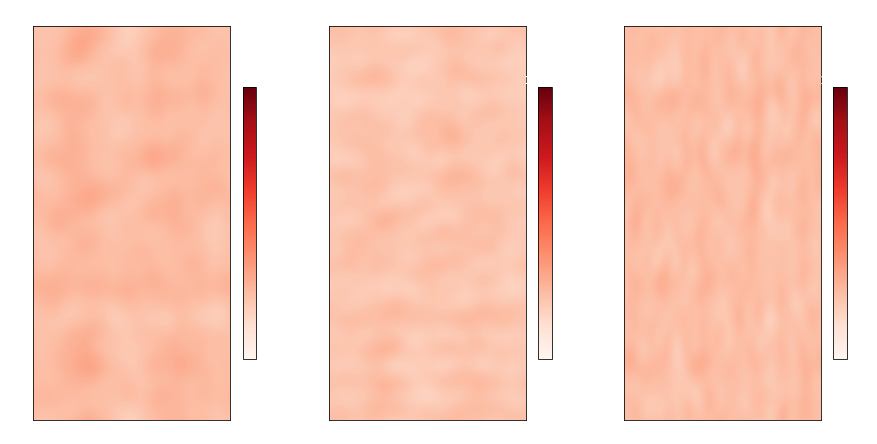

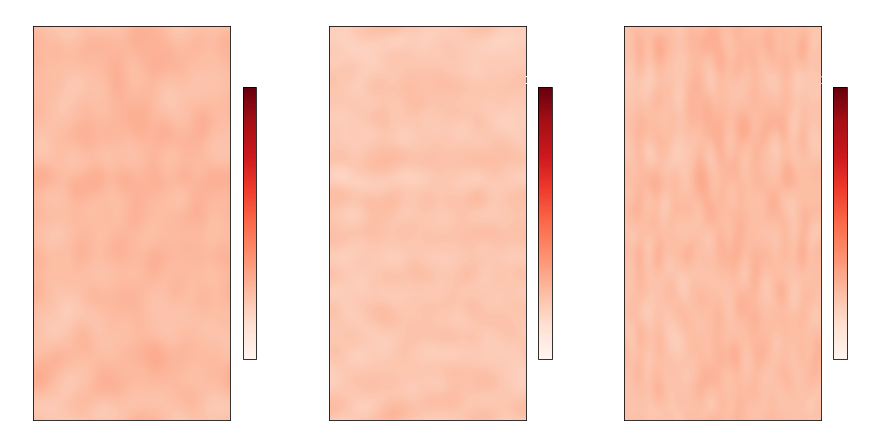

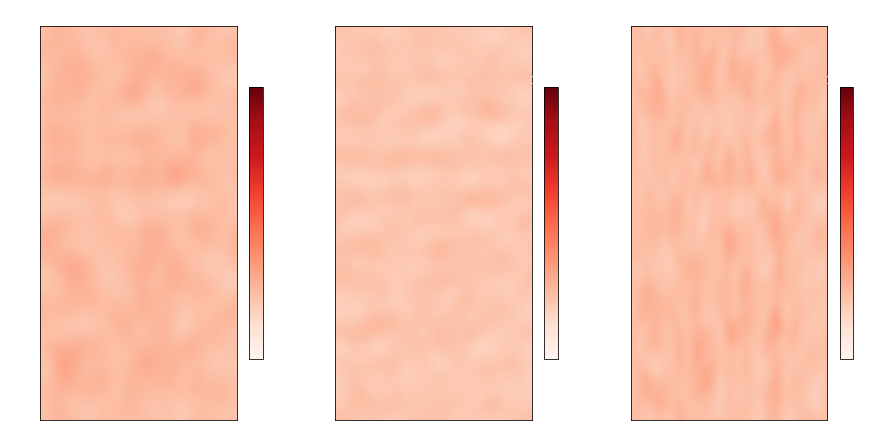

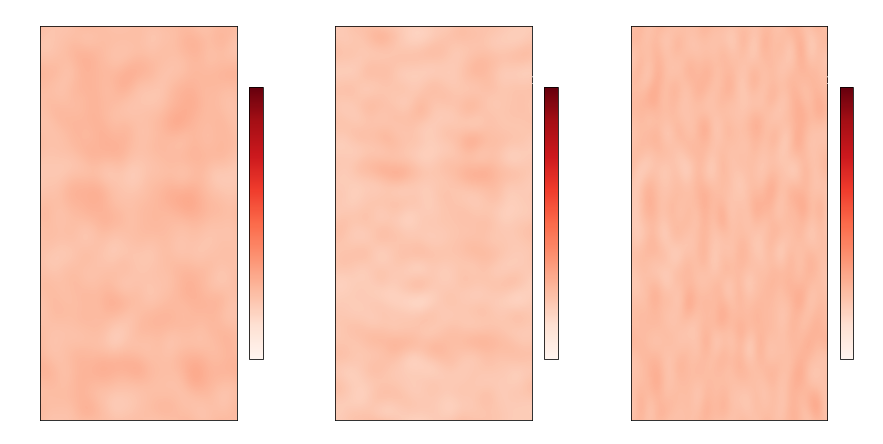

In [22]:
for l_idx in range(len(ls)):
    lvl_var = np.array(welford_vars[l_idx].finalize())
    imshow3var(lvl_var, huv_lim=1e-5)

In [23]:
vars = np.array([np.sqrt(np.average(np.array(wv.finalize())**2, axis=(1,2))) for wv in welford_vars])
diff_vars = np.array([np.sqrt(np.average(np.array(wv.finalize())**2, axis=(1,2))) for wv in welford_diff_vars])

In [24]:
gridcells = []
for l_idx in range(len(ls)):
    gridcells.append( model_error_args_list[l_idx]["nx"]*model_error_args_list[l_idx]["ny"] )

In [25]:
from utils.BasinAnalysis import *

In [26]:
analysis = Analysis(ls, vars, diff_vars)

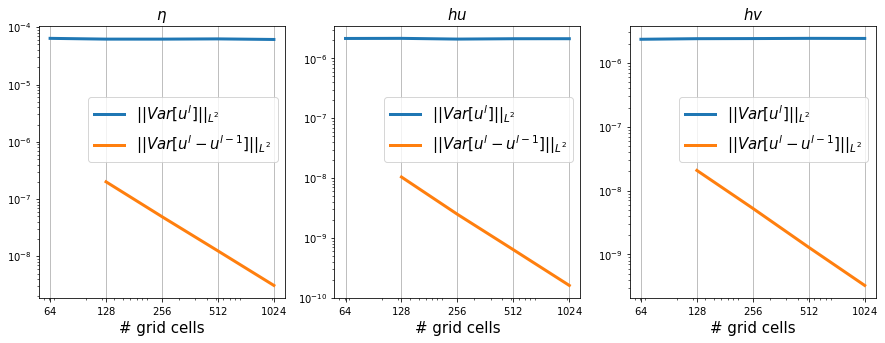

In [27]:
analysis.plotLvlVar()

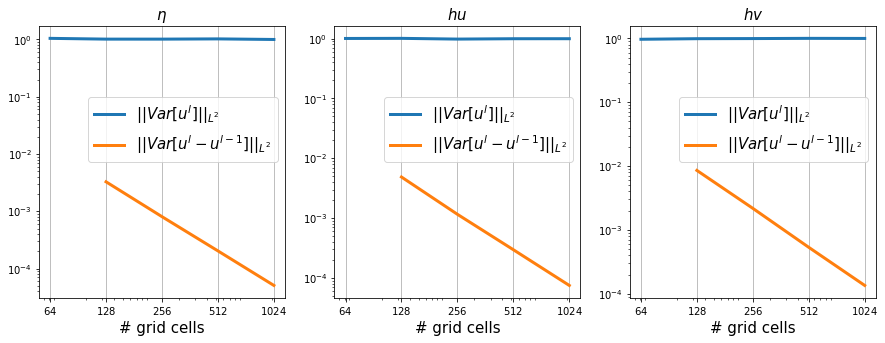

In [28]:
analysis.plotLvlVar(relative=True)

In [34]:
ML_Ne = analysis.optimal_Ne(tau=1e-7)
ML_Ne

Check the right cell size here!
Check the right cell size here!
Check the right cell size here!
Check the right cell size here!
Check the right cell size here!


array([15133,   562,   140,    35,     9], dtype=int32)

In [30]:
STOP

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2507266/2165152129.py", line 1, in <module>
    STOP
NameError: name 'STOP' is not defined


NameError: name 'STOP' is not defined